# **Brain Tumor Classification**

In [1]:
# Checking colab GPU availability
import torch
print(torch.cuda.is_available())

True


In [2]:
%pip install imutils

# **Importing required libraries**

In [3]:
# Importing required libraries
import zipfile
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import h5py
import seaborn as sns
import time
import random
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np


# **Loading Dataset**

In [4]:
# Loading dataset
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset file
zip_file_name = "brain_mri_dataset.zip"

# Unzipping the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/brain_mri_dataset")



# **Removing Bias from the Dataset**

In [5]:
# Removing Bias from the Dataset
data_dir = "brain_mri_dataset/brain_mri_dataset/Dataset"

# Delete extra images in classes with more than 350 images
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_images = os.listdir(class_path)
        if len(class_images) > 1300:
            # Randomly select 1300 images
            images_to_keep = random.sample(class_images, 1300)
            for image in class_images:
                if image not in images_to_keep:
                    os.remove(os.path.join(class_path, image))


# **Splitting the Dataset**

In [6]:
# Splitting the Dataset

# original dataset directory
original_dataset_dir = 'brain_mri_dataset/brain_mri_dataset/Dataset'
# split dataset directory
base_dir = 'brain_mri_dataset_split'
# creating directory if does not exists
os.makedirs(base_dir, exist_ok=True)

# Split ratio
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Function to copy the files to the new location
def copy_files(files, dest_folder, label):
    for file in files:
        shutil.copy(file, os.path.join(base_dir, dest_folder, label))

# Function to split data and move into corresponding folders
def split_data(original_dataset_dir, base_dir, train_size, valid_size, test_size):
    labels = [label for label in os.listdir(original_dataset_dir) if not label.startswith('.')]

    for label in labels:
        # Creating subdirectories for train, validation, and test within each label's folder if not exists
        os.makedirs(os.path.join(base_dir, 'train', label), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'valid', label), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'test', label), exist_ok=True)

        # Getting all image files under current label
        label_path = os.path.join(original_dataset_dir, label)
        files = [os.path.join(label_path, f) for f in os.listdir(label_path) if not f.startswith('.')]  # Exclude hidden files

        # Splitting image files into training, validation, and test sets
        train_files, test_files = train_test_split(files, test_size=0.2)
        valid_files, test_files = train_test_split(test_files, test_size=0.5)

        # Copying the files to its respective directories
        copy_files(train_files, 'train', label)
        copy_files(valid_files, 'valid', label)
        copy_files(test_files, 'test', label)

split_data(original_dataset_dir, base_dir, train_ratio, validation_ratio, test_ratio)

print(f"Split completed. Check the contents in '{base_dir}' directory.")


Split completed. Check the contents in 'brain_mri_dataset_split' directory.


## **Cropping an Image**

In [7]:
# # Function  to crop an image

def Crop_image(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them.
    """
    # Ensure input is a NumPy array
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Handle grayscale images
    if len(img.shape) == 2:  # Grayscale images have only height and width
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Convert RGB to GRAY
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Smoothing image while preserving edges
    gray_img = cv2.GaussianBlur(gray_img, (3, 3), 0)

    # Thresholding to remove unnecessary pixels
    _, img_thresh = cv2.threshold(gray_img, 45, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(img_thresh, None, iterations=2)
    img_dilate = cv2.dilate(img_erode, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(img_dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        raise ValueError("No contours found in the image.")

    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Visualize (optional, can be removed)
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 0, 0), -1)

    # Crop the image
    Add_pixel = 0
    img_crop = img[extTop[1]-Add_pixel:extBot[1]+Add_pixel, extLeft[0]-Add_pixel:extRight[0]+Add_pixel]

    return img_cnt, img_pnt, img_crop  # Contoured image, image with extreme points, cropped image


# **Preprocessing the Data**

In [24]:

# Directory where the preprocessed data will be stored
preprocessed_base_dir = 'preprocessed_brain_mri_dataset_split'
os.makedirs(preprocessed_base_dir, exist_ok=True)

# Function to preprocess images
def preprocess_images(input_dir, output_dir):
    labels = os.listdir(input_dir)
    print(labels)
    for label in labels:
        input_label_dir = os.path.join(input_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        os.makedirs(output_label_dir, exist_ok=True)

        # Process images under the current label directory
        for filename in os.listdir(input_label_dir):
            img_path = os.path.join(input_label_dir, filename)
            output_path = os.path.join(output_label_dir, filename)

            try:
                # Open and preprocess the image
                with Image.open(img_path) as img:
                    # Convert RGBA to RGB if necessary
                    if img.mode == 'RGBA':
                        img = img.convert('RGB')

                    # Resizing the image to 64x64
                    # img = img.resize((128, 128))

                    img_np = np.array(img)
                    # crop the current image
                    _,_, img_crop = Crop_image(img_np)

                    # resize it
                    img = cv2.resize(img_crop, dsize=(128,128), interpolation=cv2.INTER_LANCZOS4)

                    # Removing noise
                    dnoise_img = cv2.bilateralFilter(img, 2, 50,50)

                    # Applying colormap bone to highlight important features
                    cmap_img = cv2.applyColorMap(dnoise_img, cv2.COLORMAP_BONE) #cv2.COLORMAP_JET

                    # Normalize pixel values to be between 0 and 1
                    img_array = np.array(cmap_img) / 255.0

                    # Saving the preprocessed image
                    preprocessed_img = Image.fromarray((img_array * 255).astype('uint8'))
                    preprocessed_img.save(output_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Preprocess train, valid, and test sets
preprocess_images('brain_mri_dataset_split/train', os.path.join(preprocessed_base_dir, 'train'))
preprocess_images('brain_mri_dataset_split/valid', os.path.join(preprocessed_base_dir, 'valid'))
preprocess_images('brain_mri_dataset_split/test', os.path.join(preprocessed_base_dir, 'test'))

print(f"Image preprocessing completed. Preprocessed data is saved in '{preprocessed_base_dir}' directory.")


['0', '3', '1', '2']
['0', '3', '1', '2']
['0', '3', '1', '2']
Image preprocessing completed. Preprocessed data is saved in 'preprocessed_brain_mri_dataset_split' directory.


# **Transforming images data to tensors and preparing data loaders**

In [25]:
# Transforming images data to tensors and preparing data loaders

transform = transforms.Compose([
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

train_directory = '/content/preprocessed_brain_mri_dataset_split/train'
val_directory = '/content/preprocessed_brain_mri_dataset_split/valid'
test_directory = '/content/preprocessed_brain_mri_dataset_split/test'

# Creating Training , validation and testing datasets
trainSet = torchvision.datasets.ImageFolder(root=train_directory, transform=transform)
valSet =  torchvision.datasets.ImageFolder(root=val_directory, transform=transform)
testSet = torchvision.datasets.ImageFolder(root=test_directory, transform =transform)

print(trainSet)

# Creating the dataLoaders
train_loader = DataLoader(trainSet,batch_size=64, shuffle=True)
val_loader = DataLoader(valSet,batch_size=64, shuffle=True)
test_loader = DataLoader(testSet,batch_size=64, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 4160
    Root location: /content/preprocessed_brain_mri_dataset_split/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# **Data Distribution**

{0: 0, 1: 0, 2: 0, 3: 0}


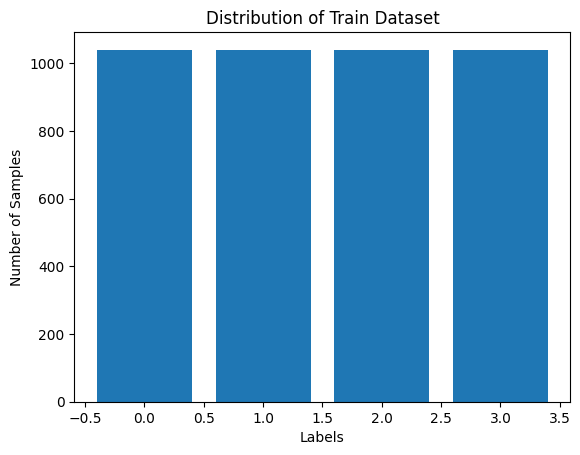

{0: 0, 1: 0, 2: 0, 3: 0}


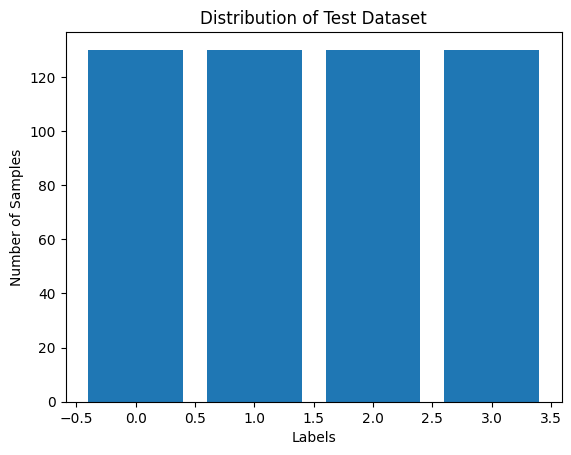

{0: 0, 1: 0, 2: 0, 3: 0}


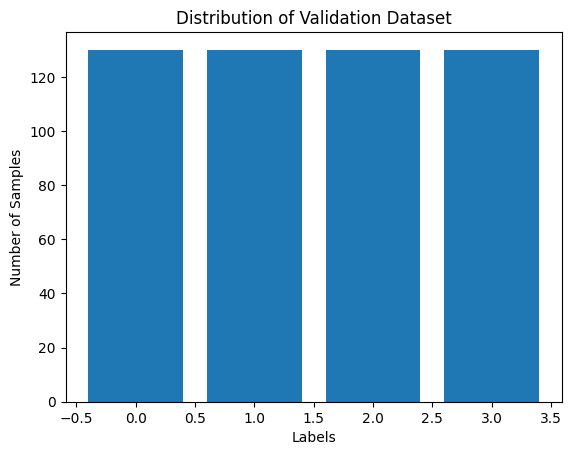

In [26]:
num_classes=4
def plot_data_distribution(loader, loader_name):
    label_count = {i: 0 for i in range(num_classes)}
    print(label_count)
    for _, labels in loader:
        for label in labels.numpy():
            label_count[label] += 1

    labels = list(label_count.keys())
    count = list(label_count.values())

    # Plotting graph
    fig, ax = plt.subplots()
    ax.bar(labels, count)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Distribution of {loader_name} Dataset')
    plt.show()

# Plot Data distribution of loaders
plot_data_distribution(train_loader, "Train")
plot_data_distribution(test_loader, "Test")
plot_data_distribution(val_loader, "Validation")

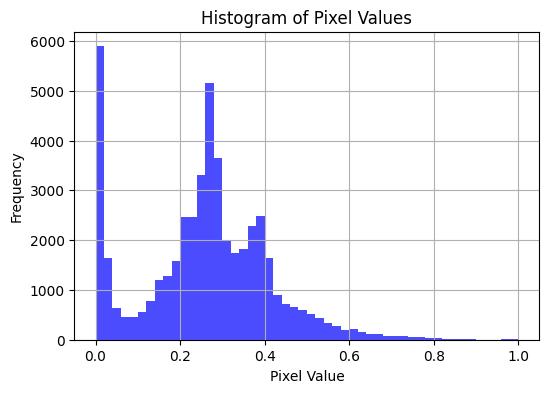

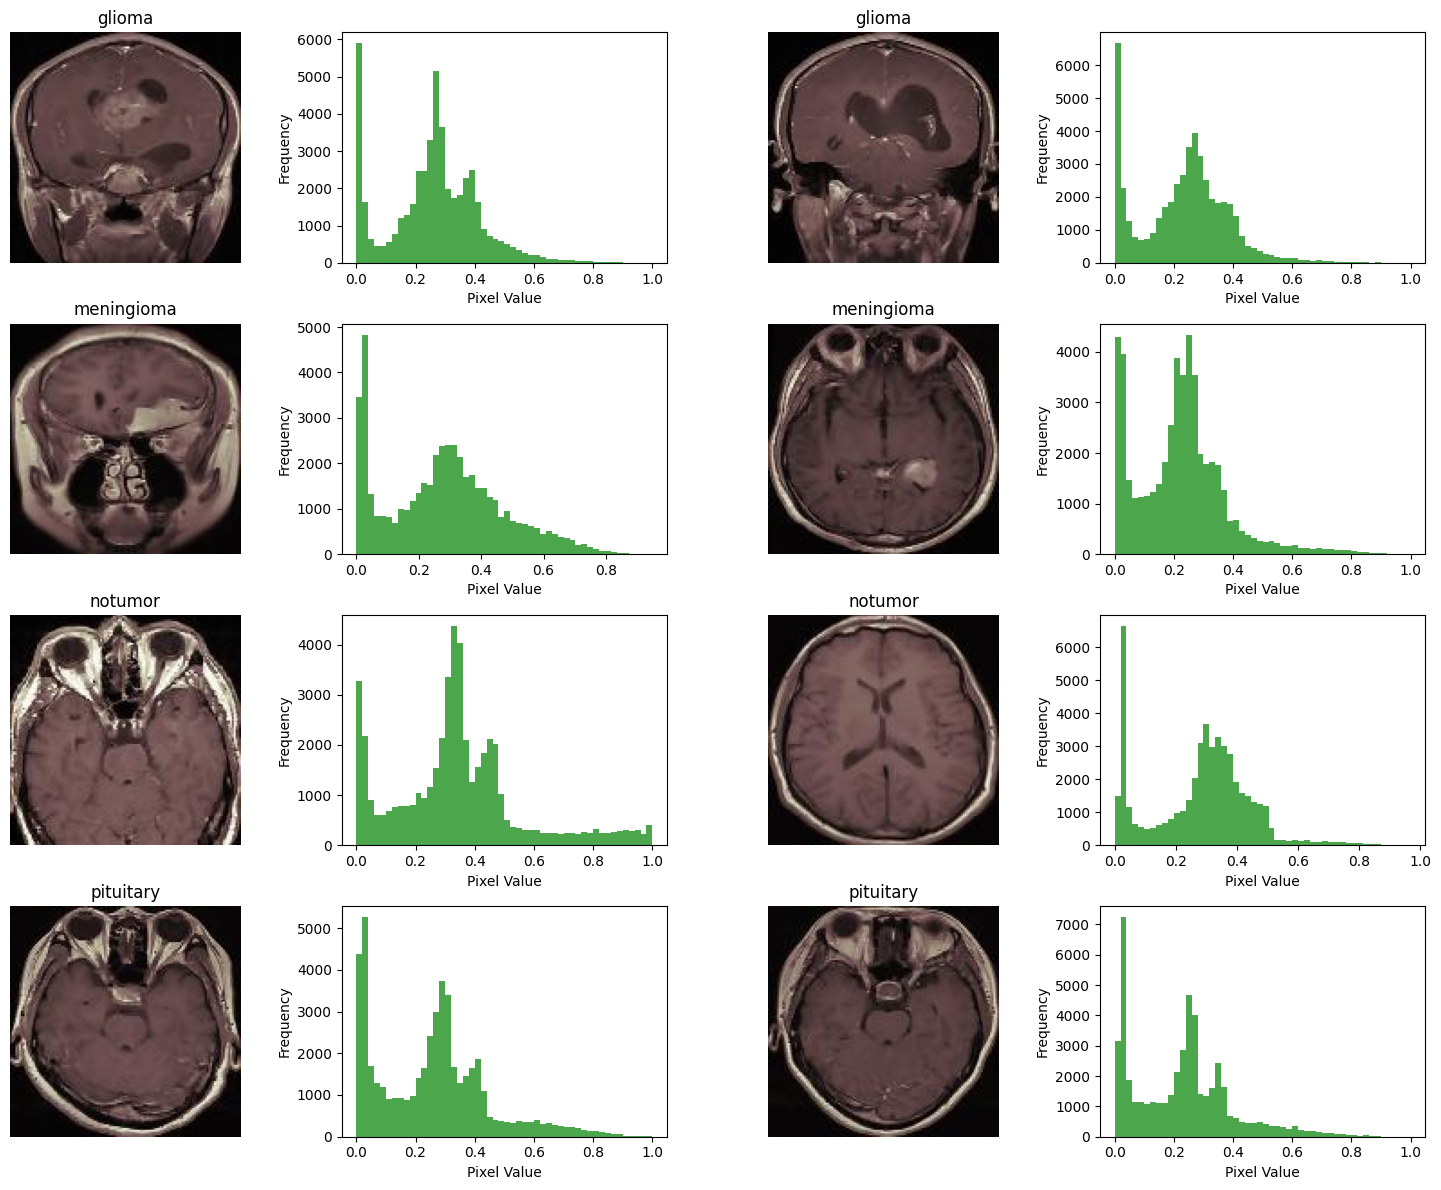

In [27]:

# Plot histogram of pixel values
def plot_histogram(image_tensor):
    flattened_image = image_tensor.view(-1)
    plt.figure(figsize=(6, 4))  # Resize the histogram plot
    plt.hist(flattened_image.numpy(), bins=50, color='blue', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values')
    plt.grid(True)
    plt.show()

# Display a grid of images with histograms for each class
def display_images_with_histograms(dataset, class_names, num_images=2):
    """
    Displays a grid of images for each class with their histograms.
    """
    plt.figure(figsize=(15, len(class_names) * 3))  # Dynamic figure size
    img_idx = 1  # Subplot counter

    for i, class_name in enumerate(class_names):
        # Get the indices of the images belonging to the current class
        indices = np.where(np.array(dataset.targets) == i)[0]
        selected_indices = indices[:num_images]  # Pick a few images

        for index in selected_indices:
            image, _ = dataset[index]
            image_np = image.permute(1, 2, 0).numpy().squeeze()  # Convert to numpy

            # Image subplot
            plt.subplot(len(class_names), num_images * 2, img_idx)
            plt.imshow(image_np, cmap='gray')
            plt.title(f"{class_name}")
            plt.axis('off')
            img_idx += 1

            # Histogram subplot
            plt.subplot(len(class_names), num_images * 2, img_idx)
            plt.hist(image_np.ravel(), bins=50, color='green', alpha=0.7)
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            img_idx += 1

    plt.tight_layout()
    plt.show()

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot histogram of a single image
sample_image, _ = trainSet[0]
plot_histogram(sample_image)

# Display grid of images with histograms
display_images_with_histograms(trainSet, class_names)


Saving Model Weights

In [28]:
# Saving Weights
def save_best_weights(model, filename):
    with h5py.File(filename, 'w') as fi:
        for name, param in model.state_dict().items():
             fi.create_dataset(name, data=param.cpu().numpy())

# **VGG13 Model:**

In [63]:
# VGG13 Model with Optimization Techniques

# Defining VGG-13 CNN architecture
class VGG(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Creating a VGG model instance
vgg13_opt_model = VGG(num_classes=4)

# Display the model architecture
vgg13_opt_model

# Moving the model to GPU
vgg13_opt_model = vgg13_opt_model.cuda()

# Displaying model summary
summary(vgg13_opt_model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           3,584
              ReLU-2        [-1, 128, 128, 128]               0
       BatchNorm2d-3        [-1, 128, 128, 128]             256
            Conv2d-4        [-1, 128, 128, 128]         147,584
              ReLU-5        [-1, 128, 128, 128]               0
       BatchNorm2d-6        [-1, 128, 128, 128]             256
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
      BatchNorm2d-13          [-1, 256, 64, 64]             512
        MaxPool2d-14          [-1, 256,

# **Training VGG-13 Model**

In [64]:

# Define loss function and optimizer with L2 regularization
vgg13_opt_criterion = nn.CrossEntropyLoss()
vgg13_opt_optimizer = optim.SGD(vgg13_opt_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Define L2 regularization function
# def l2_regularization(model, lambda_l2=0.01):
#     l2_reg = torch.tensor(0., device=device)
#     for param in model.parameters():
#         l2_reg += torch.norm(param)
#     return lambda_l2 * l2_reg

# A Variable to keep track of the best validation loss
vgg13_opt_best_val_loss = float('inf')

# Variable to keep track of the number of epochs without improvement and a counter
vgg13_opt_early_stopping_patience = 3
vgg13_opt_early_stopping_counter = 0

# Lists to store accuracies and losses of each subset of all epochs
vgg13_opt_train_accuracies = []
vgg13_opt_train_losses = []
vgg13_opt_validation_accuracies = []
vgg13_opt_validation_losses = []
vgg13_opt_test_accuracies = []
vgg13_opt_test_losses = []
vgg13_opt_num_epochs = 10

# Training loop with early stopping
vgg13_opt_start_time = time.time()
for epoch in range(vgg13_opt_num_epochs):
    vgg13_opt_train_loss = 0.0
    vgg13_opt_train_crct = 0
    vgg13_opt_train_tot = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
        vgg13_opt_optimizer.zero_grad()
        outputs = vgg13_opt_model(inputs)
        labels = labels.view(-1)
        vgg13_opt_loss = vgg13_opt_criterion(outputs, labels) #+ l2_regularization(vgg13_opt_model)
        vgg13_opt_train_loss += vgg13_opt_loss
        vgg13_opt_loss.backward()
        vgg13_opt_optimizer.step()
        _, preds = torch.max(outputs, 1)
        vgg13_opt_train_tot += labels.size(0)
        vgg13_opt_train_crct += (preds == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{vgg13_opt_num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {vgg13_opt_train_loss.item():.4f}')
    vgg13_opt_train_loss /= len(train_loader)
    vgg13_opt_train_acc = 100 * vgg13_opt_train_crct / vgg13_opt_train_tot

    # Validating the model
    with torch.no_grad():
        vgg13_opt_val_loss = 0.0
        vgg13_opt_val_crct = 0
        vgg13_opt_val_tot = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = vgg13_opt_model(inputs)
            labels = labels.view(-1)
            vgg13_opt_val_loss += vgg13_opt_criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            vgg13_opt_val_tot += labels.size(0)
            vgg13_opt_val_crct += (preds == labels).sum().item()
        vgg13_opt_val_loss /= len(val_loader)
        vgg13_opt_val_acc = 100 * vgg13_opt_val_crct / vgg13_opt_val_tot

    # Evaluating our model on test data
    vgg13_opt_all_preds = []
    vgg13_opt_all_labels = []
    with torch.no_grad():
        vgg13_opt_test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = vgg13_opt_model(inputs)
            labels = labels.view(-1)
            vgg13_opt_test_loss += vgg13_opt_criterion(outputs, labels).item()
            # Apply softmax and calculate accuracy
            softmax_outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(softmax_outputs, 1)
            # _, preds = torch.max(outputs, 1)
            vgg13_opt_all_preds.extend(preds.tolist())
            vgg13_opt_all_labels.extend(labels.tolist())


        # Calculate metrics
        vgg13_opt_test_loss /= len(test_loader)
        vgg13_opt_test_acc = accuracy_score(vgg13_opt_all_labels, vgg13_opt_all_preds)*100
        vgg13_opt_precision, vgg13_opt_recall, vgg13_opt_f1, _ = precision_recall_fscore_support(vgg13_opt_all_labels, vgg13_opt_all_preds, average='weighted')

        # Displaying calculated evaluation metrics of our model
        print(f'Accuracy: {vgg13_opt_test_acc:.2f}%')
        print(f'Precision: {vgg13_opt_precision:.2f}')
        print(f'Recall: {vgg13_opt_recall:.2f}')
        print(f'F1 Score: {vgg13_opt_f1:.2f}')

    vgg13_opt_train_accuracies.append(vgg13_opt_train_acc)
    vgg13_opt_train_losses.append(vgg13_opt_train_loss)
    vgg13_opt_validation_accuracies.append(vgg13_opt_val_acc)
    vgg13_opt_validation_losses.append(vgg13_opt_val_loss)
    vgg13_opt_test_accuracies.append(vgg13_opt_test_acc)
    vgg13_opt_test_losses.append(vgg13_opt_test_loss)

    # Check if the validation loss has improved
    if vgg13_opt_val_loss < vgg13_opt_best_val_loss:
        vgg13_opt_best_val_loss = vgg13_opt_val_loss
        vgg13_opt_early_stopping_counter = 0
        # Save the best model if improved
        torch.save(vgg13_opt_model.state_dict(), 'best_vgg13_opt_model.pth')
        save_best_weights(vgg13_opt_model, 'vgg13_opt_model_weights.h5')
    else:
        vgg13_opt_early_stopping_counter += 1

    #  Stop training the model if the validation loss does not improve for 'early_stopping_patience' epochs
    if vgg13_opt_early_stopping_counter >= vgg13_opt_early_stopping_patience:
        print("Early stopping after {} epochs without improvement.".format(vgg13_opt_early_stopping_patience))
        break

vgg13_opt_send_time=time.time()
# Loading the best model for evaluation
vgg13_opt_model.load_state_dict(torch.load('best_vgg13_opt_model.pth'))
vgg13_opt_model.eval()

print("Time to Train: ", vgg13_opt_send_time-vgg13_opt_start_time)
print("Train Accuracies: ",vgg13_opt_train_accuracies)
print("Train Losses: ",vgg13_opt_train_losses)
print("Test Accuracies: ",vgg13_opt_test_accuracies)
print("Test Losses: ",vgg13_opt_test_losses)
print("Validation Accuracies: ",vgg13_opt_validation_accuracies)
print("Validation Losses: ",vgg13_opt_validation_losses)



Accuracy: 63.08%
Precision: 0.63
Recall: 0.63
F1 Score: 0.63
Accuracy: 80.00%
Precision: 0.80
Recall: 0.80
F1 Score: 0.80
Accuracy: 81.15%
Precision: 0.81
Recall: 0.81
F1 Score: 0.81
Accuracy: 84.62%
Precision: 0.85
Recall: 0.85
F1 Score: 0.84
Accuracy: 87.31%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Accuracy: 89.62%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Accuracy: 90.77%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Accuracy: 91.54%
Precision: 0.92
Recall: 0.92
F1 Score: 0.91
Accuracy: 91.54%
Precision: 0.91
Recall: 0.92
F1 Score: 0.91
Accuracy: 92.69%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Time to Train:  365.23304986953735
Train Accuracies:  [53.05288461538461, 70.09615384615384, 81.0576923076923, 85.48076923076923, 88.75, 91.25, 93.4375, 95.04807692307692, 95.45673076923077, 95.76923076923077]
Train Losses:  [tensor(1.1494, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.8033, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5390, device='cuda:0', grad_fn=<DivBackwa

<ipython-input-64-c092a15afd99>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg13_opt_model.load_state_dict(torch.load('best_vgg13_opt_model.pth'))


# **Evaluation Metrics of VGG-13 Model**

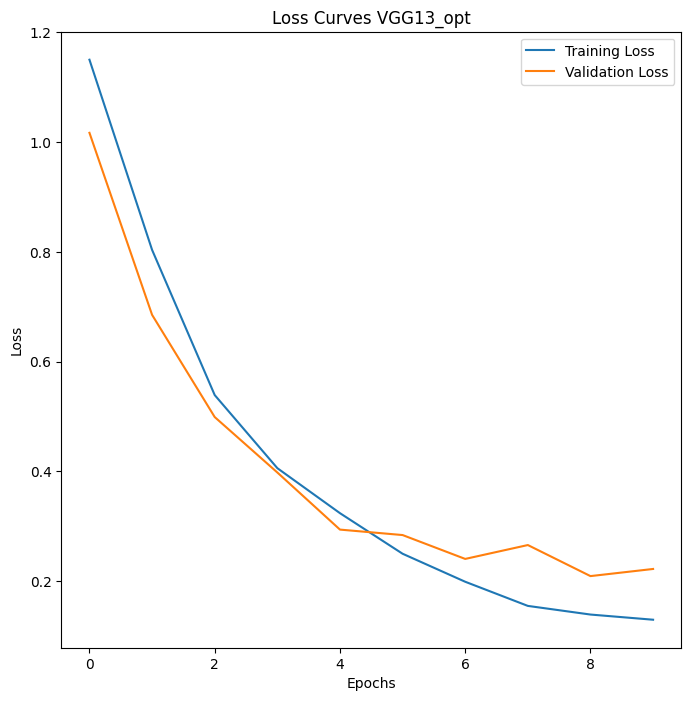

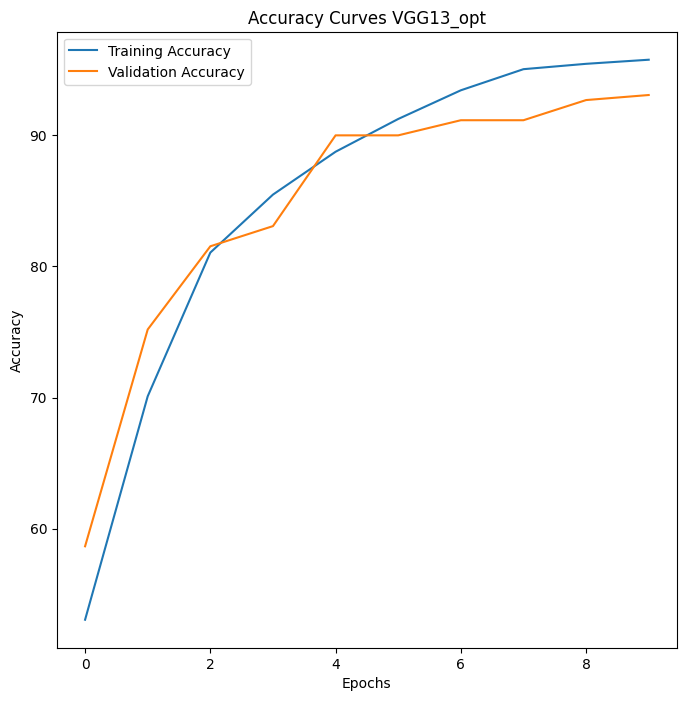

In [65]:
# Loss curves for VGG13_opt

vgg13_opt_train_losses_tensor = torch.tensor(vgg13_opt_train_losses)
vgg13_opt_validation_losses_tensor = torch.tensor(vgg13_opt_validation_losses)
# vgg13_opt_test_losses_tensor = torch.tensor(vgg13_opt_test_losses)

vgg13_opt_train_losses_cpu = vgg13_opt_train_losses_tensor.cpu().numpy()
vgg13_opt_validation_losses_cpu = vgg13_opt_validation_losses_tensor.cpu().numpy()
# vgg13_opt_test_losses_cpu = vgg13_opt_test_losses_tensor.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(vgg13_opt_train_losses_cpu, label="Training Loss")
plt.plot(vgg13_opt_validation_losses_cpu, label="Validation Loss")
# plt.plot(vgg13_opt_test_losses_cpu, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves VGG13_opt")

plt.show()

# Accuracy curves for VGG13_opt

vgg13_opt_train_accuracies_tensor = torch.tensor(vgg13_opt_train_accuracies)
vgg13_opt_validation_accuracies_tensor = torch.tensor(vgg13_opt_validation_accuracies)
# vgg13_opt_test_accuracies_tensor = torch.tensor(vgg13_opt_test_accuracies)

vgg13_opt_train_accuracies_cpu = vgg13_opt_train_accuracies_tensor.cpu().numpy()
vgg13_opt_validation_accuracies_cpu = vgg13_opt_validation_accuracies_tensor.cpu().numpy()
# vgg11_opt_test_accuracies_cpu = vgg11_opt_test_accuracies_tensor.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(vgg13_opt_train_accuracies_cpu, label="Training Accuracy")
plt.plot(vgg13_opt_validation_accuracies_cpu, label="Validation Accuracy")
# plt.plot(vgg13_opt_test_accuracies_cpu, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves VGG13_opt")

plt.show()

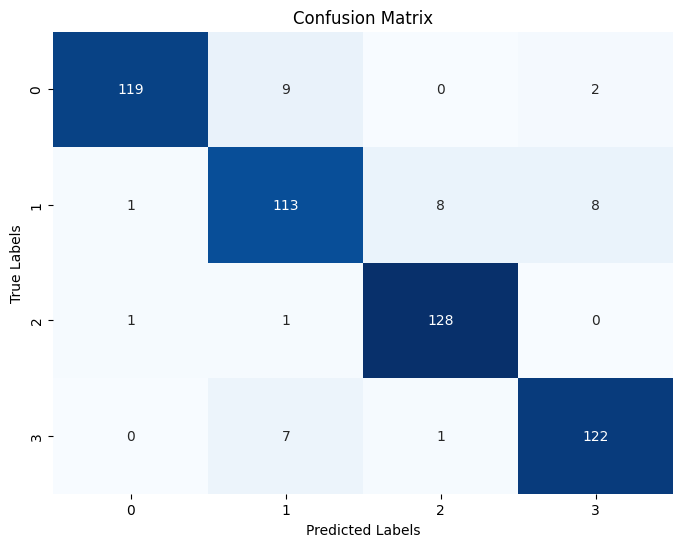

In [66]:
# Confusion Matrix for VGG13_opt

conf_matrix = confusion_matrix(vgg13_opt_all_labels, vgg13_opt_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **ResNet18 Architecture:**

In [33]:
# Defining Resnet18 Architecture

# Define the residual block
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #images are stored in identity to be added to output
        identity = x
        #first block
        out = self.relu(self.bn1(self.conv1(x)))
        #second block
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)
        #add identity to retain original input
        out = self.relu(out + identity)
        return out


# Define the ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=43):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.add_layer(block, 64, layers[0])
        self.layer2 = self.add_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.add_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.add_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def add_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the ResNet-18 model
resnet18 = ResNet18(ResidualBlock, [2, 2, 2, 2])
resnet18.to('cuda')


# # Print model summary
# print(resnet18)

# Displaying model summary
summary(resnet18, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
    ResidualBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

# **Training ResNet-18 model**

In [58]:
criterion = nn.CrossEntropyLoss()

# Define optimizer with weight decay
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-4)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Modify the training loop to include early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, patience=3, num_epochs=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improvement_count = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
            torch.save(model.state_dict(), 'resnet18_model.pth')
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet18, train_loader, val_loader, criterion, optimizer, patience=10, num_epochs=20)

Epoch 1/20, Train Loss: 0.0187, Val Loss: 0.2086, Train Accuracy: 0.9942, Val Accuracy: 0.9500
Epoch 2/20, Train Loss: 0.0275, Val Loss: 0.3276, Train Accuracy: 0.9909, Val Accuracy: 0.9019
Epoch 3/20, Train Loss: 0.0111, Val Loss: 0.2352, Train Accuracy: 0.9966, Val Accuracy: 0.9423
Epoch 4/20, Train Loss: 0.0148, Val Loss: 0.2902, Train Accuracy: 0.9957, Val Accuracy: 0.9385
Epoch 5/20, Train Loss: 0.0326, Val Loss: 0.4955, Train Accuracy: 0.9870, Val Accuracy: 0.8885
Epoch 6/20, Train Loss: 0.0230, Val Loss: 0.4595, Train Accuracy: 0.9913, Val Accuracy: 0.9135
Epoch 7/20, Train Loss: 0.0028, Val Loss: 0.2092, Train Accuracy: 1.0000, Val Accuracy: 0.9462
Epoch 8/20, Train Loss: 0.0067, Val Loss: 0.2536, Train Accuracy: 0.9978, Val Accuracy: 0.9385
Epoch 9/20, Train Loss: 0.0047, Val Loss: 0.2276, Train Accuracy: 0.9988, Val Accuracy: 0.9308
Epoch 10/20, Train Loss: 0.0018, Val Loss: 0.1924, Train Accuracy: 0.9995, Val Accuracy: 0.9558
Epoch 11/20, Train Loss: 0.0027, Val Loss: 0.3205

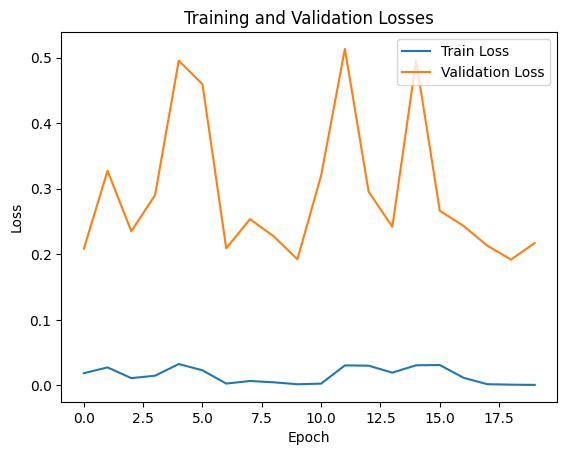

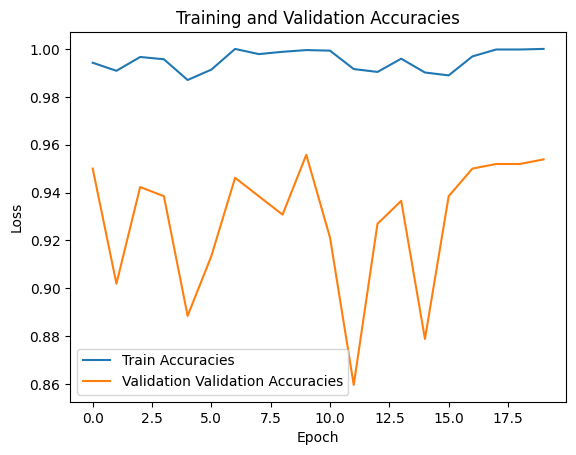

In [59]:
# Plot the training and validation losses

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracies')
plt.plot(val_accuracies, label='Validation Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# **Model Evaluation**

Test Accuracy: 96.73076923076923


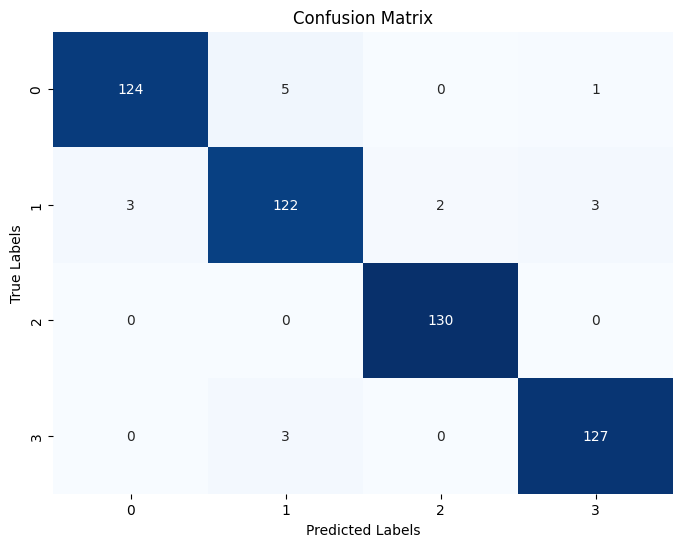

In [60]:
resnet18.eval()
test_losses = []
test_accuracies = []
test_predictions = []
true_labels = []

for images, labels in test_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = resnet18(images)
    loss = criterion(outputs, labels)
    test_losses.append(loss.item())

    _, predicted = torch.max(outputs, 1)
    test_predictions.extend(predicted.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, test_predictions)

# Display accuracy
print("Test Accuracy:", accuracy*100)

conf_matrix = confusion_matrix(true_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
#Eval Metrics
def calculate_metrics(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return precision, recall, f1

# After training
precision_train, recall_train, f1_train = calculate_metrics(resnet18, train_loader)
precision_val, recall_val, f1_val = calculate_metrics(resnet18, val_loader)

print("Train Precision:", precision_train)
print("Train Recall:", recall_train)
print("Train F1 Score:", f1_train)

print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)
print("Validation F1 Score:", f1_val)

Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Validation Precision: 0.9539989109345367
Validation Recall: 0.9538461538461539
Validation F1 Score: 0.9538734791078057
